# 决策树分类（自编算法与sklearn算法）

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as snn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,roc_curve,auc
from sklearn.tree import DecisionTreeClassifier ##决策树分类

In [3]:
data = pd.read_csv('data/heart.csv')
y = data.target
x = data.drop('target',axis=1)
X = x.values
y = y.values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## 使用sklearn.tree中的DecisionTreeClassifier进行分类预测

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



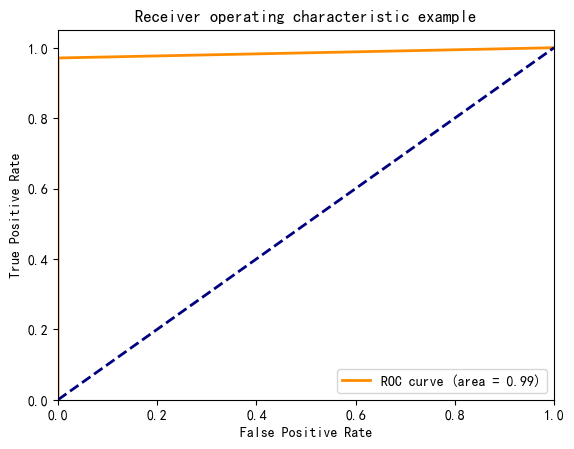

In [4]:
sklearn_model = DecisionTreeClassifier(random_state=0)
sklearn_model.fit(X_train,y_train)
y_pre = sklearn_model.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_pre))
## 绘制ROC曲线
fpr, tpr, thread =roc_curve(y_test,y_pre)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


## 自编决策树算法进行分类预测(未进行后剪枝)

In [5]:
import numpy as np 
from math import log
from collections import Counter
import random
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import utils
import pandas as pd

### CART算法的节点类
class Node:
    def __init__(self, feature, threshold, left, right):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right

class DecisionTree_without_prune(): #这里的剪枝默认是后剪枝，因为预剪枝已经在代码中有所体现了
    def __init__(self,random_state=42,criterion='gini',max_depth=99999, min_samples_split=2,min_samples_leaf = 1) -> None:
        self.choose_tree ={} 
        self.max_depth = max_depth ## 树的最大深度,属于预剪枝操作
        self.min_samples_split = min_samples_split ##节点的样本数量最小的阈值，如果小于该值则停止生长，属于预剪枝操作
        self.min_samples_leaf = min_samples_leaf #表示叶节点所需的最小样本数，默认为 1。
        self.criterion = criterion ##用户自己选择的算法：'ID3'、'C45'、'CART' ,默认CART算法
        self.randseed = random_state  ##随机数种子
    ## 计算信息熵
    def cal_entropy(self,y):
        label = Counter(y)
        n_samples = len(y)
        return sum ([-float(label[key]) / n_samples *log(float(label[key]/ n_samples),2) for key in label])
    ## 计算基尼指数
    def _gini_impurity(self, y):
        m = len(y)
        return 1.0 - sum([(np.sum(y == c) / m) ** 2 for c in np.unique(y)])
    def _split(self,X,feature,value):
        index = np.argwhere(X[:,feature]==value).flatten()
        return np.delete(X[index,:],feature,axis=1)
    
    ## 定义统计出现标签出现次数最多的种类
    def result_y(self,y):
        label = Counter(y)
        sort = sorted(label.items(), key=lambda x: x[1],reverse=True)
        return sort[0][0]
    ## 首先基于数据集D基尼指数、然后计算特征向量feature中值为threshold的基尼指数，二者相减，计算增量
    def _gini_gain(self, y, feature, threshold):
        parent_gini = self._gini_impurity(y) ##计算当前数据集的基尼指数
        left_idxs = np.argwhere(feature<= threshold).flatten() ##计算特征feature=threshold的行索引
        right_idxs = np.argwhere(feature>threshold).flatten() ##计算特征feature！=threshold的行索引
        if len(left_idxs) == 0 or len(right_idxs) == 0: ##如果有一个行索引是空的，意味着特征的值种类只有一个
            return 0
        left_gini = self._gini_impurity(y[left_idxs]) #计算划分数据集后的数据集D1的基尼指数
        right_gini = self._gini_impurity(y[right_idxs]) ##计算D-D1数据集的基尼指数
        p_left = len(left_idxs) / len(y)
        p_right = 1 - p_left
        child_gini = p_left * left_gini + p_right * right_gini
        return parent_gini - child_gini         
 
    def ID3_CreateTree(self,X,y,feature_names,depth=0):
        n_samples,n_features = X.shape ##获取数据特征的个数
        n_labels = len(np.unique(y)) #获取因变量的种类个数
        if depth >= self.max_depth or n_labels == 1 or n_samples<=self.min_samples_split: ##如果子节点标签只有一类或者树的深度大于阈值以及子节点的样本量小于阈值，则停止生长
            return self.result_y(y) ##返回标签中样本数最多的类别
        
        ## 判断特征列的个数是否为0，如果为0就意味着不能再继续生成树了
        if len(X)==0:
            return self.result_y(y)
        entropy_begin = self.cal_entropy(y) ##初始数据集的信息熵
        best_feature_idx = -1 #初始化最优特征索引
        best_gain = -1 #初始化信息增益
        ## 找到最优特征
        for feature_index in range(n_features): ##遍历每一个特征
            entropy_new = 0
            for threshold in  np.unique(X[:,feature_index]): #遍历特征feature_index这一列的所有可能的取值
                idxs = np.argwhere(X[:,feature_index]==threshold).flatten() ##找到特征feature_index这一列取值为threshold的行索引
                entropy_new+=len(idxs)/n_samples*self.cal_entropy(y[idxs])
            gain = entropy_begin -entropy_new ##计算当前特征的信息增益
            if gain>best_gain:
                best_gain = gain 
                best_feature_idx = feature_index
        
        ## 开始生成ID3决策树
        best_feature_name = feature_names[best_feature_idx]
        del(feature_names[best_feature_idx])
        tree = {best_feature_name:{}}
        for fea_val in np.unique(X[:,best_feature_idx]):
            idx = np.argwhere(X[:,best_feature_idx]==fea_val).flatten()
            subfeature_names = feature_names[:] #拷贝,更改subfeature_names的值不会影响feature_names
            tree[best_feature_name][fea_val] = self.ID3_CreateTree(self._split(X,best_feature_idx,fea_val),y[idx],subfeature_names,depth=depth+1)
        return tree
   
    def C45_CreateTree(self,X,y,feature_names,depth = 0):
        n_samples,n_features = X.shape ##获取数据特征的个数
        n_labels = len(np.unique(y)) #获取因变量的种类个数
        if depth >= self.max_depth or n_labels == 1 or n_samples<=self.min_samples_split: ##如果子节点标签只有一类或者树的深度大于阈值以及子节点的样本量小于阈值，则停止生长
            return self.result_y(y) ##返回标签中样本数最多的类别
        
        ## 判断特征列的个数是否为0，如果为0就意味着不能再继续生成树了
        if len(X)==0:
            return self.result_y(y)
        
        entropy_begin = self.cal_entropy(y) ##初始数据集的信息熵
        best_feature_idx = -1 #初始化最优特征索引
        best_gain_ratio = 0.0
        
        ## 找到最优特征
        for feature_index in range(n_features): ##遍历每一个特征
            entropy_new = 0.0
            IV =0.0
            for threshold in  np.unique(X[:,feature_index]): #遍历特征feature_index这一列的所有可能的取值
                idxs = np.argwhere(X[:,feature_index]==threshold).flatten() ##找到特征feature_index这一列取值为threshold的行索引
                suby = y[idxs]
                entropy_new+=len(suby)/len(y)*self.cal_entropy(suby)
                IV -= len(suby)/ len(y)*log(len(suby) / len(y),2)
            gain = entropy_begin -entropy_new ##计算当前特征的信息增益
            if IV==0:
                continue
            info_gain_ratio = float(gain/IV) ##当前特征的信息增益比
            if info_gain_ratio>best_gain_ratio:
                best_gain_ratio = info_gain_ratio 
                best_feature_idx = feature_index
        
        ## 开始生成C4.5决策树
        best_feature_name = feature_names[best_feature_idx]
        del (feature_names[best_feature_idx])
        tree = {best_feature_name:{}}
        for fea_val in np.unique(X[:,best_feature_idx]):
            subfeature_names = feature_names[:] #拷贝,更改subfeature_names的值不会影响feature_names
            idx = np.argwhere(X[:,best_feature_idx]==fea_val).flatten()
            tree[best_feature_name][fea_val] = self.C45_CreateTree(self._split(X,best_feature_idx,fea_val),y[idx],subfeature_names,depth=depth+1)
        return tree
    
    ## 
    def CART_CreateTree(self, X, y, depth=0): ## X是数据特征，y是标签
        n_samples,n_features = X.shape ##获取数据特征的个数
        n_labels = len(np.unique(y)) #获取因变量的种类个数

        if depth >= self.max_depth or n_labels == 1 or n_samples<self.min_samples_split: ##如果二叉树的分支大于默认的最大分支个数或者因变量的标签种类个数为1
            return self.result_y(y) ##返回标签中样本数最多的类别

        best_gain = -1
        for feature_idx in range(n_features): ## 遍历每一个特征
            for threshold in np.unique(X[:, feature_idx]):#遍历特征向量的每一个不同的取值
                gain = self._gini_gain(y, X[:, feature_idx], threshold)  ##第feature_idx个特征向量值为threshold的基尼增长数值
                if gain > best_gain:
                    best_gain = gain  ##选择增益最大的
                    best_feature = feature_idx ##增益最大相应的特征索引
                    best_threshold = threshold ##相应的最优切分点

        left_idxs = np.argwhere(X[:,best_feature] <=best_threshold).flatten() 
        right_idxs = np.argwhere(X[:,best_feature]>best_threshold).flatten()
        if len(left_idxs) <self.min_samples_leaf or len(right_idxs) <self.min_samples_leaf:
            return self.result_y(y)
        left_tree = self.CART_CreateTree(X[left_idxs, :], y[left_idxs], depth + 1) ##递归生成二叉树的左侧部分
        right_tree = self.CART_CreateTree(X[right_idxs, :], y[right_idxs], depth + 1) ##递归生成二叉树的右侧部分
        return Node(best_feature, best_threshold, left_tree, right_tree) ##将最优特征与最优切分点、二叉树左侧、二叉树右侧存入Node类
    
    def CART_predict(self, inputs):
        node = self.choose_tree
        while isinstance(node, Node):
            if inputs[node.feature] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node  
    
    ## 基于ID3算法与C4.5算法的
    def classify(self, feat_labels, test_vec):
        #zip()函数将iterables中每个可迭代对象中的元素依次取出，打包成元组，并返回一个迭代器，其中第n个元组包含了每个可迭代对象中第n个元素。
        #iterables是一个或多个可迭代对象，可以是列表、元组、集合、字典等
        test_data = dict(zip(feat_labels, test_vec))
        current_node = self.choose_tree
        while isinstance(current_node, dict): ##检查一个对象是否是字典的实例
            feature_name = list(current_node.keys())[0]
            feature_value = test_data[feature_name]
            if feature_value not in current_node[feature_name]:
                random.seed(self.randseed)
                rand_node = random.randint(0,len(self.labels)-1)
                current_node = self.labels[rand_node]
                break
            current_node = current_node[feature_name][feature_value]
        return current_node
    
    # 定义训练函数
    def fit(self,X_train,y_train):
        self.labels = np.unique(y_train)
        feature_name = [i for i in range(X_train.shape[1])]
        if self.criterion =='ID3':
            self.choose_tree = self.ID3_CreateTree(X_train,y_train,feature_name)  
        elif self.criterion=='C45':
            self.choose_tree = self.C45_CreateTree(X_train,y_train,feature_name)  
        elif self.criterion =='gini':
            self.choose_tree = self.CART_CreateTree(X_train,y_train)
        return self.choose_tree      
    ## 定义预测函数
    def predict(self,X_test):
        classLabel =[]
        feature_names = [i for i in range(X_test.shape[1])]
        if isinstance(self.choose_tree,dict):      
            for testVec in X_test:
                classLabel.append(self.classify(feature_names,testVec))
        else:
            classLabel = [self.CART_predict(inputs) for inputs in X_test]
        return np.array(classLabel)
 
 

### 基于简单二分类数据集

In [6]:
print('决策树算法应用在二分类简单数据集:')
dataSet=np.array([[0, 0, 0, 0, 'no'],
            [0, 0, 0, 1, 'no'],
            [0, 1, 0, 1, 'yes'],
            [0, 1, 1, 0, 'yes'],
            [0, 0, 0, 0, 'no'],
            [1, 0, 0, 0, 'no'],
            [1, 0, 0, 1, 'no'],
            [1, 1, 1, 1, 'yes'],
            [1, 0, 1, 2, 'yes'],
            [1, 0, 1, 2, 'yes'],
            [2, 0, 1, 2, 'yes'],
            [2, 0, 1, 1, 'yes'],
            [2, 1, 0, 1, 'yes'],
            [2, 1, 0, 2, 'yes'],
            [2, 0, 0, 0, 'no']])
X  = dataSet[:,:-1]
y = dataSet[:,-1]
demo = DecisionTree_without_prune(random_state=0,criterion='ID3')
demo.fit(X,y)
pre = demo.predict(X)
print(pre)

决策树算法应用在二分类简单数据集:
['no' 'no' 'yes' 'yes' 'no' 'no' 'no' 'yes' 'yes' 'yes' 'yes' 'yes' 'yes'
 'yes' 'no']


### 基于复杂二分类数据集

决策树算法应用在二分类heart.csv数据集:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



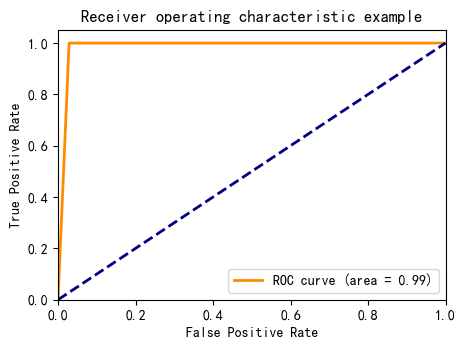

In [7]:
print('决策树算法应用在二分类heart.csv数据集:')
data_2 = pd.read_csv('data/heart.csv')
y = data_2.target
x = data_2.drop('target',axis=1)
X = x.values
y = y.values
X_train_2,X_test_2,y_train_2,y_test_2 = train_test_split(X,y,test_size=0.2,random_state=42)
My_model_2 = DecisionTree_without_prune(random_state=42,criterion='gini')
My_model_2.fit(X_train=X_train_2,y_train=y_train_2)
y_pre_2 = My_model_2.predict(X_test=X_test_2)
print(classification_report(y_true=y_test_2,y_pred=y_pre_2))   
utils.roc_plot(y_pre_2,y_test_2)

### 基于多分类数据集

In [8]:
print('决策树算法应用在多分类数据集：')
data_= pd.read_excel('data/fisheriris.xlsx')
data_3 = data_.sample(frac=1,random_state=42)
data_3 = data_3.values
X = data_3[:,:-1]
y = data_3[:,-1]
X_train_3 = X[:100,:]
y_train_3 = y[:100]
X_test_3 = X[100:,:]
y_test_3 = y[100:]

My_model_3 = DecisionTree_without_prune(random_state=0,criterion='gini')
My_model_3.fit(X_train=X_train_3,y_train=y_train_3)
y_pre_3 = My_model_3.predict(X_test_3)
# print(y_pre_3)
print(classification_report(y_pre_3,y_test_3))

决策树算法应用在多分类数据集：
              precision    recall  f1-score   support

     setosa'       1.00      1.00      1.00        13
 versicolor'       0.89      0.89      0.89        18
  virginica'       0.89      0.89      0.89        19

    accuracy                           0.92        50
   macro avg       0.93      0.93      0.93        50
weighted avg       0.92      0.92      0.92        50



# 决策树剪枝算法

## 预剪枝算法

### 未进行预剪枝与进行预剪枝的对比

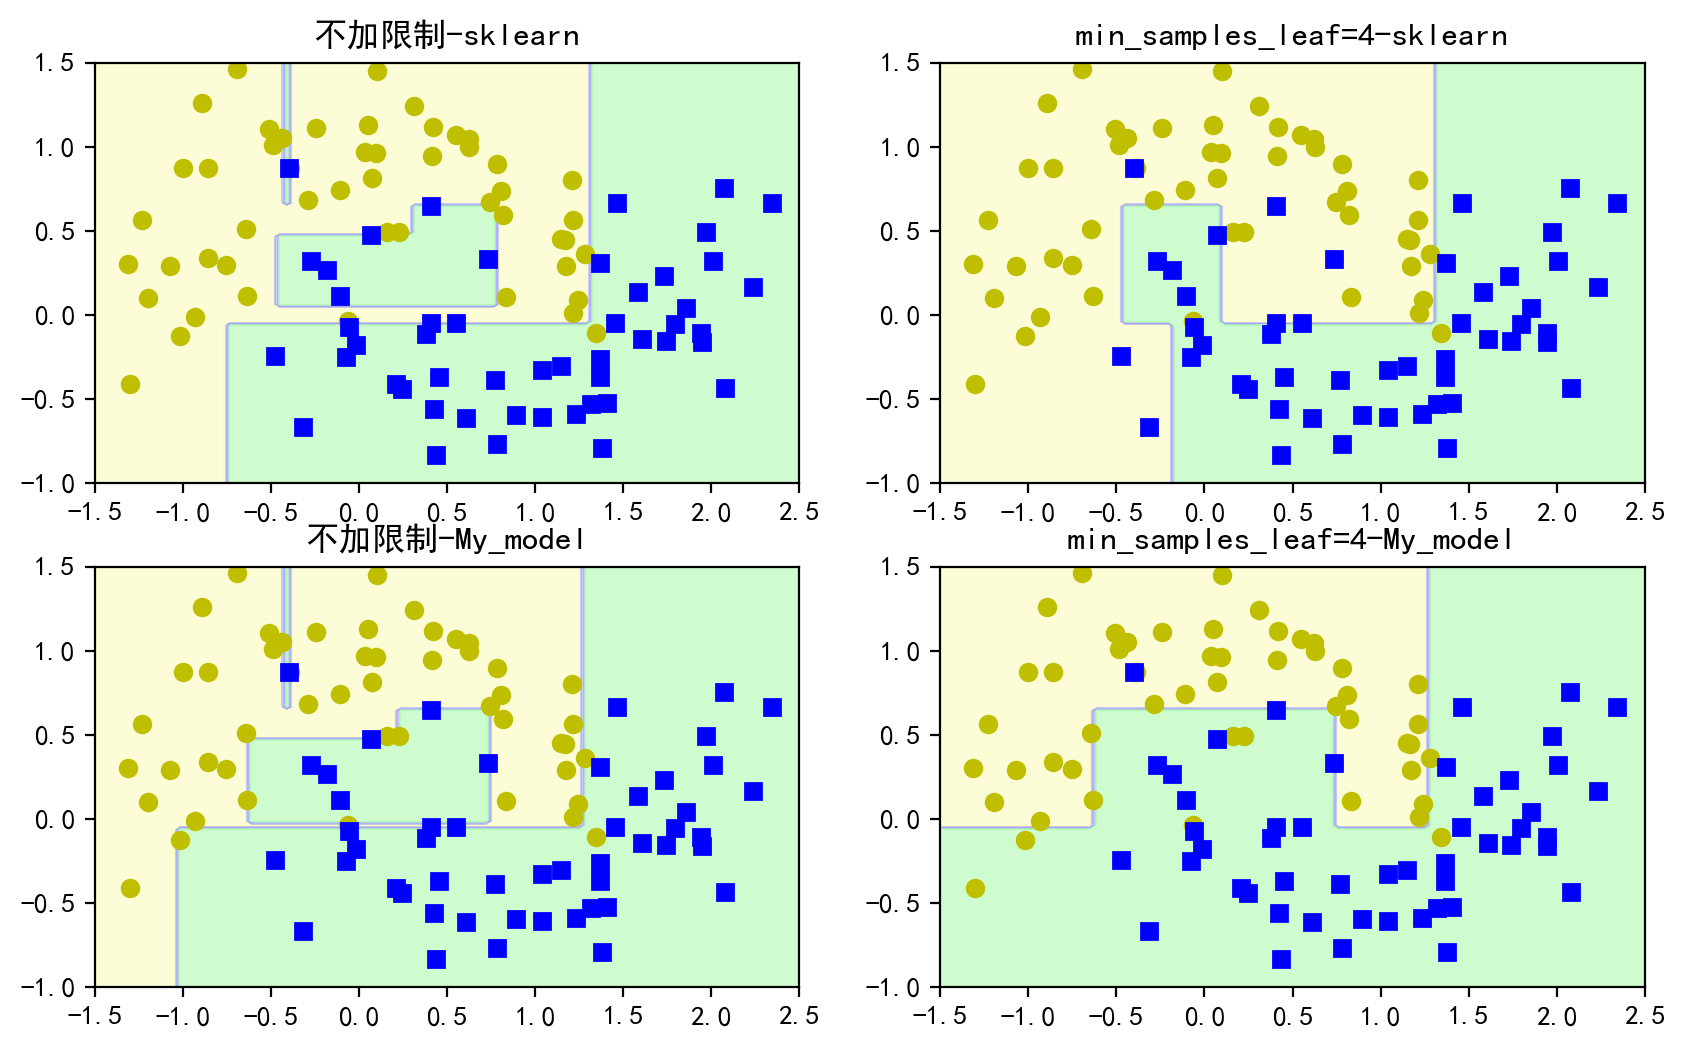

In [9]:
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import os
def plot_decision_boundary(clf,X,y,axes =[0,7.5,0,3],iris =True,legend =False):
    #显示决策树分类后的边界
    #生成x1,x2的数据
    x1s = np.linspace(axes[0],axes[1],100)
    x2s = np.linspace(axes[2],axes[3],100)
    #将x1，x2数据生成mesh网格状的数据
    x1,x2 = np.meshgrid(x1s,x2s)
    #c_ 函数用于按列方向合并两个或多个数组
    #ravel() 函数用于将多维数组展平成一维数组
    X_new = np.c_[x1.ravel(),x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    #填充等高线
    plt.contourf(x1,x2,y_pred,alpha=0.5,cmap=custom_cmap)
    #输出样本点
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False

    plt.plot(X[:,0][y==0],X[:,1][y==0],'yo',label ='Iris-Setosa')
    plt.plot(X[:,0][y==1],X[:,1][y==1],'bs',label='Iris-Versicolor')
    plt.plot(X[:,0][y==2],X[:,1][y==2],'g^',label='iris-Virginica')
    plt.axis(axes)
# 生产数据集
X,y = make_moons(n_samples=100,noise=0.3,random_state=52)
# 分别建立两颗决策树，一颗不做限制
tree_1 = DecisionTreeClassifier(random_state=42) #sklearn
tree_2 = DecisionTreeClassifier(random_state=42,min_samples_leaf=4)#sklearn
tree_3 = DecisionTree_without_prune() #自编算法,不加限制
tree_4 = DecisionTree_without_prune(min_samples_leaf=4) #自编算法
# 训练
tree_1.fit(X,y)
tree_2.fit(X,y)
tree_3.fit(X,y)
tree_4.fit(X,y)
# 作图
if not os.path.exists('Images'):
    os.mkdir('Images')
plt.figure(figsize=(10,6),dpi=200)
plt.subplot(2,2,1)
plot_decision_boundary(tree_1,X,y,axes=[-1.5,2.5,-1,1.5],iris=False)
plt.title('不加限制-sklearn')
plt.subplot(2,2,2)
plot_decision_boundary(tree_2,X,y,axes=[-1.5,2.5,-1,1.5],iris=False)
plt.title('min_samples_leaf=4-sklearn')
plt.subplot(2,2,3)
plot_decision_boundary(tree_3,X,y,axes=[-1.5,2.5,-1,1.5],iris=False)
plt.title('不加限制-My_model')
plt.subplot(2,2,4)
plot_decision_boundary(tree_4,X,y,axes=[-1.5,2.5,-1,1.5],iris=False)
plt.title('min_samples_leaf=4-My_model')
plt.savefig('Images/决策树预减枝.jpg')
plt.show()

### 后剪枝算法

In [10]:
import numpy as np 
from math import log
from collections import Counter
import random
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import utils
import pandas as pd

### CART算法的节点类
class Node:
    def __init__(self, feature, threshold, left, right):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
    def __str__(self):
        return f"Node(feature={self.feature}, threshold={self.threshold}, left={self.left}, right={self.right})"

class DecisionTree_prune():
    def __init__(self,random_state=42,criterion='gini',max_depth=99999, min_samples_split=2,min_samples_leaf = 1,Post_prune=True,train_size =0.75) -> None:
        self.choose_tree ={} 
        self.max_depth = max_depth ## 树的最大深度,属于预剪枝操作
        self.min_samples_split = min_samples_split ##节点的样本数量最小的阈值，如果小于该值则停止生长，属于预剪枝操作
        self.min_samples_leaf = min_samples_leaf #表示叶节点所需的最小样本数，默认为 1。
        self.criterion = criterion ##用户自己选择的算法：'ID3'、'C45'、'CART' ,默认CART算法
        self.randseed = random_state  ##随机数种子
        self.Post_prune = Post_prune ##后剪枝，默认为True
        self.train_size = train_size ##后剪枝中训练集的样本比例，默认为0.75
    ## 计算信息熵
    def cal_entropy(self,y):
        label = Counter(y)
        n_samples = len(y)
        return sum ([-float(label[key]) / n_samples *log(float(label[key]/ n_samples),2) for key in label])
    ## 计算基尼指数
    def _gini_impurity(self, y):
        m = len(y)
        return 1.0 - sum([(np.sum(y == c) / m) ** 2 for c in np.unique(y)])
    def _split(self,X,feature,value):
        index = np.argwhere(X[:,feature]==value).flatten()
        return np.delete(X[index,:],feature,axis=1)
    
    ## 定义统计出现标签出现次数最多的种类
    def result_y(self,y):
        label = Counter(y)
        sort = sorted(label.items(), key=lambda x: x[1],reverse=True)
        return sort[0][0]
    ## 首先基于数据集D基尼指数、然后计算特征向量feature中值为threshold的基尼指数，二者相减，计算增量
    def _gini_gain(self, y, feature, threshold):
        parent_gini = self._gini_impurity(y) ##计算当前数据集的基尼指数
        left_idxs = np.argwhere(feature<= threshold).flatten() ##计算特征feature=threshold的行索引
        right_idxs = np.argwhere(feature>threshold).flatten() ##计算特征feature！=threshold的行索引
        if len(left_idxs) == 0 or len(right_idxs) == 0: ##如果有一个行索引是空的，意味着特征的值种类只有一个
            return 0
        left_gini = self._gini_impurity(y[left_idxs]) #计算划分数据集后的数据集D1的基尼指数
        right_gini = self._gini_impurity(y[right_idxs]) ##计算D-D1数据集的基尼指数
        p_left = len(left_idxs) / len(y)
        p_right = 1 - p_left
        child_gini = p_left * left_gini + p_right * right_gini
        return parent_gini - child_gini         
    
    ## 定义后剪枝算法函数
    def post_prune(self, tree, X_val, y_val):
        if not isinstance(tree,Node): #如果此时的树是叶节点,则返回当前的叶节点即可
            return tree
        n_samples = X_val.shape[0] #获取验证集的样本数量
        left_tree = tree.left #二叉树的左分枝
        right_tree = tree.right #二叉树的右分枝
        #如果二叉树的左分枝或者右分枝不是属于Node类的话，在进行递归运算，进行剪枝
        if isinstance(tree,Node):
            left_tree = self.post_prune(left_tree,X_val,y_val)
        if isinstance(tree,Node):
            right_tree = self.post_prune(right_tree,X_val,y_val)
        
        # 模拟剪枝前后的准确率，选择最优决策树
        y_pre = [self._CART_predict(inputs,tree) for inputs in X_val]
        tree_accuracy = np.sum([y_pre[i] == y_val[i] for i in range(n_samples)]) / n_samples
        left_accuracy = np.sum([self._CART_predict(X_val[i], left_tree) == y_val[i] for i in range(n_samples)]) / n_samples
        right_accuracy = np.sum([self._CART_predict(X_val[i], right_tree) == y_val[i] for i in range(n_samples)]) / n_samples
        accuracy_before_pruning = tree_accuracy # 剪枝之前的准确率
        
        cut_left = True
        if left_accuracy>right_accuracy:
            accuracy_after_pruning = left_accuracy
        else:
            accuracy_after_pruning = right_accuracy
            cut_left = False
            
        if accuracy_after_pruning>accuracy_before_pruning and cut_left: #如果左分支剪枝后的准确率大于剪枝之前的准确率
            return self.result_y(y_val)
        elif accuracy_after_pruning >accuracy_after_pruning and not cut_left:
            return self.result_y(y_val)
        else:
            return Node(tree.feature,tree.threshold,tree.left,tree.right)
        
    def ID3_CreateTree(self,X,y,feature_names,depth=0):
        n_samples,n_features = X.shape ##获取数据特征的个数
        n_labels = len(np.unique(y)) #获取因变量的种类个数
        if depth >= self.max_depth or n_labels == 1 or n_samples<=self.min_samples_split: ##如果子节点标签只有一类或者树的深度大于阈值以及子节点的样本量小于阈值，则停止生长
            return self.result_y(y) ##返回标签中样本数最多的类别
        
        ## 判断特征列的个数是否为0，如果为0就意味着不能再继续生成树了
        if len(X)==0:
            return self.result_y(y)
        entropy_begin = self.cal_entropy(y) ##初始数据集的信息熵
        best_feature_idx = -1 #初始化最优特征索引
        best_gain = -1 #初始化信息增益
        ## 找到最优特征
        for feature_index in range(n_features): ##遍历每一个特征
            entropy_new = 0
            for threshold in  np.unique(X[:,feature_index]): #遍历特征feature_index这一列的所有可能的取值
                idxs = np.argwhere(X[:,feature_index]==threshold).flatten() ##找到特征feature_index这一列取值为threshold的行索引
                entropy_new+=len(idxs)/n_samples*self.cal_entropy(y[idxs])
            gain = entropy_begin -entropy_new ##计算当前特征的信息增益
            if gain>best_gain:
                best_gain = gain 
                best_feature_idx = feature_index
        
        ## 开始生成ID3决策树
        best_feature_name = feature_names[best_feature_idx]
        del(feature_names[best_feature_idx])
        tree = {best_feature_name:{}}
        for fea_val in np.unique(X[:,best_feature_idx]):
            idx = np.argwhere(X[:,best_feature_idx]==fea_val).flatten()
            subfeature_names = feature_names[:] #拷贝,更改subfeature_names的值不会影响feature_names
            tree[best_feature_name][fea_val] = self.ID3_CreateTree(self._split(X,best_feature_idx,fea_val),y[idx],subfeature_names,depth=depth+1)
        return tree
   
    def C45_CreateTree(self,X,y,feature_names,depth = 0):
        n_samples,n_features = X.shape ##获取数据特征的个数
        n_labels = len(np.unique(y)) #获取因变量的种类个数
        if depth >= self.max_depth or n_labels == 1 or n_samples<=self.min_samples_split: ##如果子节点标签只有一类或者树的深度大于阈值以及子节点的样本量小于阈值，则停止生长
            return self.result_y(y) ##返回标签中样本数最多的类别
        
        ## 判断特征列的个数是否为0，如果为0就意味着不能再继续生成树了
        if len(X)==0:
            return self.result_y(y)
        
        entropy_begin = self.cal_entropy(y) ##初始数据集的信息熵
        best_feature_idx = -1 #初始化最优特征索引
        best_gain_ratio = 0.0
        
        ## 找到最优特征
        for feature_index in range(n_features): ##遍历每一个特征
            entropy_new = 0.0
            IV =0.0
            for threshold in  np.unique(X[:,feature_index]): #遍历特征feature_index这一列的所有可能的取值
                idxs = np.argwhere(X[:,feature_index]==threshold).flatten() ##找到特征feature_index这一列取值为threshold的行索引
                suby = y[idxs]
                entropy_new+=len(suby)/len(y)*self.cal_entropy(suby)
                IV -= len(suby)/ len(y)*log(len(suby) / len(y),2)
            gain = entropy_begin -entropy_new ##计算当前特征的信息增益
            if IV==0:
                continue
            info_gain_ratio = float(gain/IV) ##当前特征的信息增益比
            if info_gain_ratio>best_gain_ratio:
                best_gain_ratio = info_gain_ratio 
                best_feature_idx = feature_index
        
        ## 开始生成C4.5决策树
        best_feature_name = feature_names[best_feature_idx]
        del (feature_names[best_feature_idx])
        tree = {best_feature_name:{}}
        for fea_val in np.unique(X[:,best_feature_idx]):
            subfeature_names = feature_names[:] #拷贝,更改subfeature_names的值不会影响feature_names
            idx = np.argwhere(X[:,best_feature_idx]==fea_val).flatten()
            tree[best_feature_name][fea_val] = self.C45_CreateTree(self._split(X,best_feature_idx,fea_val),y[idx],subfeature_names,depth=depth+1)
        return tree
    
    ## 
    def CART_CreateTree(self, X, y, depth=0): ## X是数据特征，y是标签
        n_samples,n_features = X.shape ##获取数据特征的个数
        n_labels = len(np.unique(y)) #获取因变量的种类个数

        if depth >= self.max_depth or n_labels == 1 or n_samples<self.min_samples_split: ##如果二叉树的分支大于默认的最大分支个数或者因变量的标签种类个数为1
            return self.result_y(y) ##返回标签中样本数最多的类别

        best_gain = -1
        for feature_idx in range(n_features): ## 遍历每一个特征
            for threshold in np.unique(X[:, feature_idx]):#遍历特征向量的每一个不同的取值
                gain = self._gini_gain(y, X[:, feature_idx], threshold)  ##第feature_idx个特征向量值为threshold的基尼增长数值
                if gain > best_gain:
                    best_gain = gain  ##选择增益最大的
                    best_feature = feature_idx ##增益最大相应的特征索引
                    best_threshold = threshold ##相应的最优切分点

        left_idxs = np.argwhere(X[:,best_feature] <=best_threshold).flatten() 
        right_idxs = np.argwhere(X[:,best_feature]>best_threshold).flatten()
        if len(left_idxs) <self.min_samples_leaf or len(right_idxs) <self.min_samples_leaf:
            return self.result_y(y)
        left_tree = self.CART_CreateTree(X[left_idxs, :], y[left_idxs], depth + 1) ##递归生成二叉树的左侧部分
        right_tree = self.CART_CreateTree(X[right_idxs, :], y[right_idxs], depth + 1) ##递归生成二叉树的右侧部分
        return Node(best_feature, best_threshold, left_tree, right_tree) ##将最优特征与最优切分点、二叉树左侧、二叉树右侧存入Node类
    
    def _CART_predict(self,inputs,tree): ##用于后剪枝算法使用的预测函数
        node = tree
        while isinstance(node,Node):
            if inputs[node.feature]<=node.threshold:
                node = node.left
            else:
                node = node.right
        return node
    
    def CART_predict(self, inputs): 
        node = self.choose_tree
        while isinstance(node, Node):
            if inputs[node.feature] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node  
    
    ## 基于ID3算法与C4.5算法的
    def classify(self, feat_labels, test_vec):
        #zip()函数将iterables中每个可迭代对象中的元素依次取出，打包成元组，并返回一个迭代器，其中第n个元组包含了每个可迭代对象中第n个元素。
        #iterables是一个或多个可迭代对象，可以是列表、元组、集合、字典等
        test_data = dict(zip(feat_labels, test_vec))
        current_node = self.choose_tree
        while isinstance(current_node, dict): ##检查一个对象是否是字典的实例
            feature_name = list(current_node.keys())[0]
            feature_value = test_data[feature_name]
            if feature_value not in current_node[feature_name]:
                random.seed(self.randseed)
                rand_node = random.randint(0,len(self.labels)-1)
                current_node = self.labels[rand_node]
                break
            current_node = current_node[feature_name][feature_value]
        return current_node
    
    # 定义训练函数
    def fit(self,X_train,y_train):
        self.labels = np.unique(y_train)
        feature_name = [i for i in range(X_train.shape[1])]
        # 训练集：验证集：测试集 = 6:2:2 默认值
        train_size = int(self.train_size*X_train.shape[0])
        X_train_ = X_train[:train_size,:]
        y_train_ = y_train[:train_size]
        X_val = X_train[train_size:,:]
        y_val = y_train[train_size:]
        if self.criterion =='ID3':
            self.choose_tree = self.ID3_CreateTree(X_train,y_train,feature_name)  
        elif self.criterion=='C45':
            self.choose_tree = self.C45_CreateTree(X_train,y_train,feature_name)  
        elif self.criterion =='gini':
            if self.Post_prune: ##如果进行后剪枝
                tree = self.CART_CreateTree(X_train_,y_train_)
                self.choose_tree = self.post_prune(tree,X_val=X_val,y_val=y_val)
            else: ##如果不进行后剪枝
                self.choose_tree = self.CART_CreateTree(X_train,y_train)
        return self.choose_tree      
    ## 定义预测函数
    def predict(self,X_test):
        classLabel =[]
        feature_names = [i for i in range(X_test.shape[1])]
        if isinstance(self.choose_tree,dict):      
            for testVec in X_test:
                classLabel.append(self.classify(feature_names,testVec))
        else:
            classLabel = [self.CART_predict(inputs) for inputs in X_test]
        return np.array(classLabel)
 
 

In [11]:
# 测试一下
data_4 = pd.read_csv('data/heart.csv')
y = data_4.target
x = data_4.drop('target',axis=1)
X = x.values
y = y.values
X_train_4,X_test_4,y_train_4,y_test_4 = train_test_split(X,y,test_size=0.2,random_state=42)
demo1 = DecisionTree_prune(Post_prune=False)  ##不进行后剪枝
## 计算一下未剪枝的准确率
demo1.fit(X_train_4,y_train_4)
y_pre1 = demo1.predict(X_test=X_test_4)
print(classification_report(y_pre1,y_test_4))
## 计算一下剪枝后的准确率
demo2 = DecisionTree_prune(train_size=7/8)
demo2.fit(X_train_4,y_train_4)
y_pre2 = demo2.predict(X_test_4)
print(classification_report(y_pre2,y_test_4))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       105
           1       0.97      1.00      0.99       100

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       102
           1       1.00      1.00      1.00       103

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



In [12]:
# 测试二
print('决策树算法应用在多分类数据集：')
data_= pd.read_excel('data/fisheriris.xlsx')
data_3 = data_.sample(frac=1,random_state=42)
data_3 = data_3.values
X = data_3[:,:-1]
y = data_3[:,-1]
X_train_3 = X[:100,:]
y_train_3 = y[:100]
X_test_3 = X[100:,:]
y_test_3 = y[100:]
demo = DecisionTree_prune(train_size=7/8)
demo2 = DecisionTree_prune(Post_prune=False)

## 计算一下未剪枝的准确率
demo2.fit(X_train_3,y_train_3)
y_pre1 = demo2.predict(X_test=X_test_3)
print(classification_report(y_pre1,y_test_3))
## 计算一下剪枝后的准确率
demo.fit(X_train_3,y_train_3)
y_pre2 = demo.predict(X_test=X_test_3)
print(classification_report(y_pre2,y_test_3))


决策树算法应用在多分类数据集：
              precision    recall  f1-score   support

     setosa'       1.00      1.00      1.00        13
 versicolor'       0.89      0.89      0.89        18
  virginica'       0.89      0.89      0.89        19

    accuracy                           0.92        50
   macro avg       0.93      0.93      0.93        50
weighted avg       0.92      0.92      0.92        50

              precision    recall  f1-score   support

     setosa'       1.00      1.00      1.00        13
 versicolor'       1.00      0.95      0.97        19
  virginica'       0.95      1.00      0.97        18

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



### 未进行后剪枝与进行后剪枝的对比

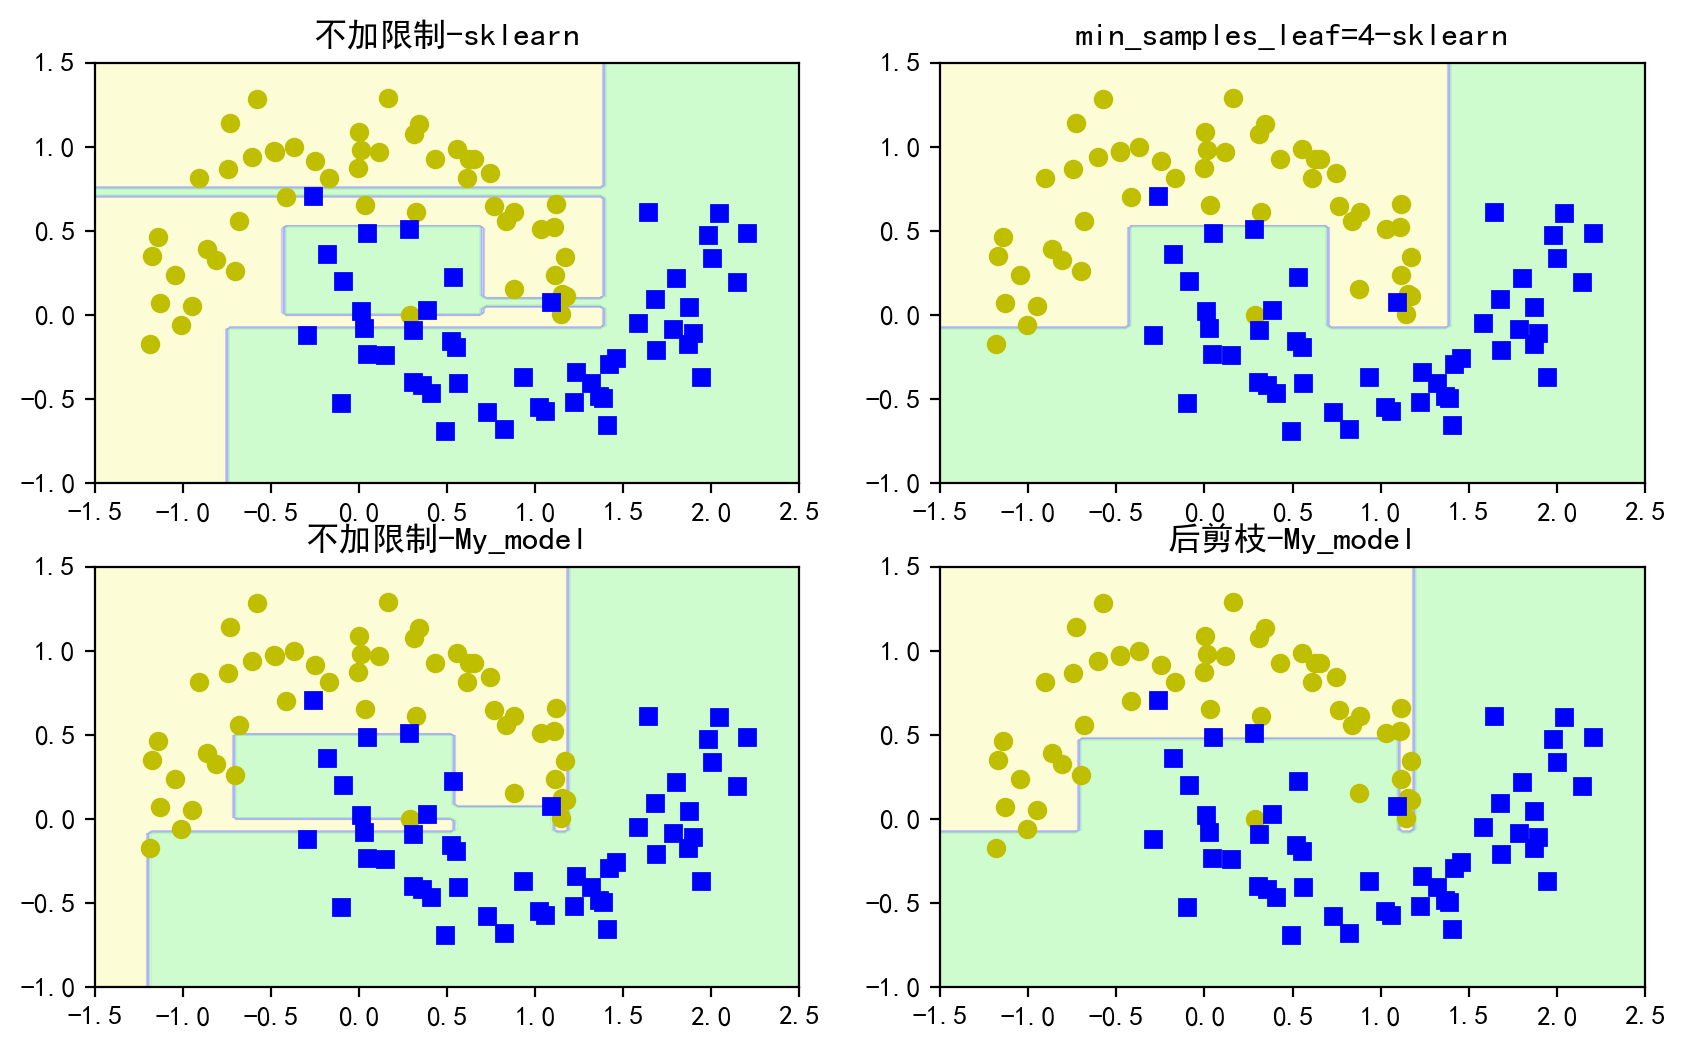

In [24]:
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import os
def plot_decision_boundary(clf,X,y,axes =[0,7.5,0,3],iris =True,legend =False):
    #显示决策树分类后的边界
    #生成x1,x2的数据
    x1s = np.linspace(axes[0],axes[1],100)
    x2s = np.linspace(axes[2],axes[3],100)
    #将x1，x2数据生成mesh网格状的数据
    x1,x2 = np.meshgrid(x1s,x2s)
    #c_ 函数用于按列方向合并两个或多个数组
    #ravel() 函数用于将多维数组展平成一维数组
    X_new = np.c_[x1.ravel(),x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    #填充等高线
    plt.contourf(x1,x2,y_pred,alpha=0.5,cmap=custom_cmap)
    #输出样本点
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False

    plt.plot(X[:,0][y==0],X[:,1][y==0],'yo',label ='Iris-Setosa')
    plt.plot(X[:,0][y==1],X[:,1][y==1],'bs',label='Iris-Versicolor')
    plt.plot(X[:,0][y==2],X[:,1][y==2],'g^',label='iris-Virginica')
    plt.axis(axes)
# 生产数据集
X,y = make_moons(n_samples=100,noise=0.2,random_state=52)
# 分别建立两颗决策树，一颗不做限制
tree_1 = DecisionTreeClassifier(random_state=42) #sklearn
tree_2 = DecisionTreeClassifier(random_state=42,min_samples_leaf=4)#sklearn
tree_3 = DecisionTree_prune(Post_prune=False) #自编算法,不加限制
tree_4 = DecisionTree_prune(train_size=0.85,min_samples_leaf=4) #自编算法
# 训练
tree_1.fit(X,y)
tree_2.fit(X,y)
tree_3.fit(X,y)
tree_4.fit(X,y)
# 作图
if not os.path.exists('Images'):
    os.mkdir('Images')
plt.figure(figsize=(10,6),dpi=200)
plt.subplot(2,2,1)
plot_decision_boundary(tree_1,X,y,axes=[-1.5,2.5,-1,1.5],iris=False)
plt.title('不加限制-sklearn')
plt.subplot(2,2,2)
plot_decision_boundary(tree_2,X,y,axes=[-1.5,2.5,-1,1.5],iris=False)
plt.title('min_samples_leaf=4-sklearn')
plt.subplot(2,2,3)
plot_decision_boundary(tree_3,X,y,axes=[-1.5,2.5,-1,1.5],iris=False)
plt.title('不加限制-My_model')
plt.subplot(2,2,4)
plot_decision_boundary(tree_4,X,y,axes=[-1.5,2.5,-1,1.5],iris=False)
plt.title('后剪枝-My_model')
plt.savefig('Images/决策树后剪枝.jpg')
plt.show()

# 总结
从以上几个数据集上的例子可以观察到，后剪枝算法可以有效地控制过拟合现象，其中DecisionClassify()中的Post_prune默认是True,即
默认进行后剪枝，参数train_size根据你的数据集的情况来选择，本代码默认train_size为0.75。

**注意：**：决策树的后剪枝操作有可能会降低模型在测试集上的预测准确率，可以根据参数train_size调整出最优的模型，当然后剪枝的
最大优点在与降低了模型复杂度，提高了模型的泛化能力。

## 2023-5-5改动
- 新增加了决策树可视化的操作,但是仅限于决策树数据结构为**字典**型，Node型决策树的可视化还未解决
- 可视化操作的函数在utils文件内，只需要导入utils模块即可

决策树算法应用在二分类简单数据集可视化:
{'有自己的房子': {'0': {'有工作': {'0': 'no', '1': 'yes'}}, '1': 'yes'}}


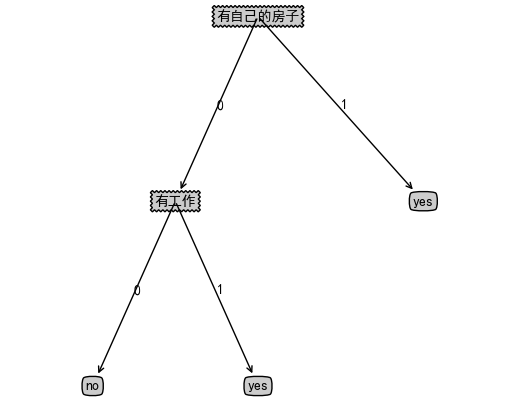

In [28]:
print('决策树算法应用在二分类简单数据集可视化:')
dataSet=np.array([[0, 0, 0, 0, 'no'],
            [0, 0, 0, 1, 'no'],
            [0, 1, 0, 1, 'yes'],
            [0, 1, 1, 0, 'yes'],
            [0, 0, 0, 0, 'no'],
            [1, 0, 0, 0, 'no'],
            [1, 0, 0, 1, 'no'],
            [1, 1, 1, 1, 'yes'],
            [1, 0, 1, 2, 'yes'],
            [1, 0, 1, 2, 'yes'],
            [2, 0, 1, 2, 'yes'],
            [2, 0, 1, 1, 'yes'],
            [2, 1, 0, 1, 'yes'],
            [2, 1, 0, 2, 'yes'],
            [2, 0, 0, 0, 'no']])
X  = dataSet[:,:-1]
y = dataSet[:,-1]
demo = DecisionTree_without_prune()
demo.fit(X,y)
feature_names = ['年龄','有工作','有自己的房子','信贷情况']
tree = demo.C45_CreateTree(X=X,y=y,feature_names=feature_names)
print(tree)
utils.createPlot(tree)